# HCDR Pipeline - Phase 4

## Setup

### Imports

In [1]:
# import packages

# system
import os
import time
import warnings
import zipfile
import pickle

# data engineering
import numpy as np
import pandas as pd 
from pandas.plotting import scatter_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# machine learning
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import recall_score


# deep learning
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

warnings.filterwarnings('ignore')

print(f"cuda available?\n{torch.cuda.is_available()}")

cuda available?
False


### Custom Classes

In [2]:
# transformer reduces the list of columns by a subset
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

# transformer produces a reduced column list by collinearity reduction
class CollinearityReducer(BaseEstimator, TransformerMixin):
    
    '''
    This class reduces features by measuring collinearity between the input variables and target.
    Works on numerical features based on the correlations between each variable pair.
    Of the var1iable pairs with absolute correlations above the threshold value...
    ...the variables with the lowest target variable correlation are dropped from the input X.
    The process is repeated until there are no more colinear pairs with absolute correlations above the threshold.
    ...Or max_iter. 
    
    The transformation returns a subset of feature names... 
    ...to be used with the DataFrameSelector() Class. 

    This class is meant to be run at the end of the numerical pipeline
    PRIOR TO THE ACTUAL PIPELINE - only returns subset for DataFrameSelector().

    NOTE! The function receives a dataframe structured with the target variable in first column.
    '''
    
    def __init__(self, attribute_names, threshold=0.5, max_iter=None):
        self.attribute_names = attribute_names
        self.threshold = threshold
        self.max_iter = max_iter
            
    def fit(self, X, y):
        return self
    
    def transform(self, X, y=None): 

        # TODO: address dataframe error when used with pytorch model       
        dataframe = pd.concat([y, pd.DataFrame(X)], axis=1)
        
        i = 0
        while i <= self.max_iter:

            # read-in and assign columns
            # gets correlation matrix between variables and pivots to a longer df
            # identify target variable
            # drop same-name and target correlations pairs
              
            df = dataframe
            features = df.iloc[:,1:].columns
            target_name = df.iloc[:,0].name

            df = pd.melt(abs(df.corr()).reset_index(), id_vars='index', value_vars=features)
            targets = df[df['index']==target_name]
            df = df[(df['index'] != df['variable']) & (df['index'] != target_name) & (df['variable'] != target_name)]

            # combine the correlated variables into ordered pairs
            # aggregate the max correlation and sort pairs
            # split out the variables from the pair
            # join the target variable correlations for each variable pair, rename columns

            df['joined'] = df[['index', 'variable']].apply(lambda row: '::'.join(np.sort(row.values.astype(str))), axis=1)

            df = df.groupby('joined', as_index=False) \
                   .agg({'value':'max'}) \
                   .sort_values(by='value', ascending=False)

            df[['var_1','var_2']] = df['joined'].str.split("::",expand=True).astype(int)

            df = df.merge(targets, how='left', left_on='var_1', right_on='variable') \
                   .merge(targets, how='left', left_on='var_2', right_on='variable')
            df.rename(columns = {'value_x':'var_pair_corr', 'value_y':'var_1_target_corr', 'value':'var_2_target_corr'}, inplace = True)

            # This section takes all variable pairs with a correlation greater than threshold
            # tests to determine which variable has a higher correlation with the target.
            # The higher of the two gets marked as a win
            # While the other gets marked as a loss
            # the wins and losses for each variable are then grouped and summed

            exceeds = df[df['var_pair_corr']>self.threshold]

            # break if none above threshold
            if len(exceeds['var_pair_corr'])==0:
                break

            # "correlation competition"
            exceeds['var_1_win'] = exceeds.apply(lambda row: 1 if row["var_1_target_corr"] >= row["var_2_target_corr"] else 0, axis=1)
            exceeds['var_1_loss'] = exceeds.apply(lambda row: 1 if row["var_2_target_corr"] >= row["var_1_target_corr"] else 0, axis=1)
            exceeds['var_2_win'] = exceeds.apply(lambda row: 1 if row["var_1_target_corr"] < row["var_2_target_corr"] else 0, axis=1)
            exceeds['var_2_loss'] = exceeds.apply(lambda row: 1 if row["var_2_target_corr"] < row["var_1_target_corr"] else 0, axis=1)

            # aggregate scores
            var1 = exceeds[['var_1', 'var_1_win', 'var_1_loss']].groupby('var_1', as_index=False) \
                                                                .agg({'var_1_win':'sum', 'var_1_loss':'sum'})
            var1.rename(columns = {'var_1':'var', 'var_1_win':'win', 'var_1_loss':'loss'}, inplace=True)

            var2 = exceeds[['var_2', 'var_2_win', 'var_2_loss']].groupby('var_2', as_index=False) \
                                                                .agg({'var_2_win':'sum', 'var_2_loss':'sum'})
            var2.rename(columns = {'var_2':'var', 'var_2_win':'win', 'var_2_loss':'loss'}, inplace=True)

            corrcomps = pd.concat([var1,var2], axis=0).groupby('var', as_index=False) \
                                                      .agg({'win':'sum', 'loss':'sum'})

            # drop variables which had 0 wins - IE collinear variables which were always least related to the target
            dropvars = corrcomps[corrcomps['win']==0]['var']

            dataframe = dataframe.drop(dropvars, axis=1)  

            i += 1  
        
        X = [self.attribute_names[col] for col in dataframe.columns]

        return X

### Custom Functions

In [3]:
# function identifies missing data
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent']) 


# function to identify different feature types and summary EDA
def id_num_cat_feature(df,text = True):
    numerical = df.select_dtypes(include=np.number).columns
    categorical = df.select_dtypes(include=['object', 'bool', 'category']).columns
    feat_num = list(numerical)
    feat_cat = list(categorical)
    
    id_cols = ['SK_ID_CURR','SK_ID_BUREAU']
    
    id_cols = [cols for cols in  list(df.columns.intersection(id_cols))] 
    features = list(set(df.columns) - set(id_cols))

    if text == True:
          # print eda
        print('--------')
        print(f"# of ID's: {len(id_cols)}")
        print(f" ID's:")
        print(id_cols)
        print('')
        print('--------')
        print(f"# All features: {len(features)}")
        print(f"All features:")
        print(features)
        print('')
        print(f"Missing data:")
        print(missing_data(df[features]))
        print('')
        print('--------')
        print(f"# of Numerical features: {len(feat_num)}")
        print(f"Numerical features:")
        print(feat_num)
        print('')
        print(f"Numerical Statistical Summary:")
        print('')
        print(df[feat_num].describe())
        print('')
        print('--------')
        print(f"# of Categorical features: {len(feat_cat)}")
        print(f"Categorical features:")
        print(feat_cat)
        print('')
        print(f"Categorical Statistical Summary:")
        print('')
        #print(df[feat_cat].describe(include='all'))
        print('')
        print("Categories:")
        print('')
        print(df[feat_cat].apply(lambda col: col.unique()))
        print('')
        print('--------')
        
    return id_cols,feat_num,feat_cat,features


# https://pythonsimplified.com/how-to-handle-large-datasets-in-python-with-pandas/

def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**3
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**3
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [4]:
#
# Method to create, define and run a deep neural network model
#
def run_hcdr_model(
    hidden_layer_neurons=[32, 16, 8],
    opt=optim.SGD,
    epochs=5,
    learning_rate=4e-3,
    return_model=False
):
    
    D_in = X_test.shape[1]  # Input layer neurons depend on the input dataset shape
    D_out = 2  # Output layer neurons - depend on what you're trying to predict, here, 2 classes: 0 and 1
    
    str_neurons = [str(h) for h in hidden_layer_neurons]
    arch_string = f"{D_in}-{'-'.join(str_neurons)}-{D_out}"
    
    layers = [
        torch.nn.Linear(D_in, hidden_layer_neurons[0]),  # X.matmul(W1)
        nn.ReLU()  # ReLU( X.matmul(W1))
    ]
    
    # Add hidden layers
    for i in range(1, len(hidden_layer_neurons)):
        prev, curr = hidden_layer_neurons[i - 1], hidden_layer_neurons[i]
        if i%2==0:
            layers.append(torch.nn.Linear(prev, curr))
            layers.append(nn.ReLU())
        else:
            layers.append(torch.nn.Linear(prev, curr))
            layers.append(nn.ReLU())
    
    # Add final layer
    layers.append(nn.Linear(hidden_layer_neurons[-1], D_out)) # Relu( X.matmul(W1)).matmul(W2))
    
    # Use the nn package to define our model and loss function.
    # use the sequential API makes things simple
    model = torch.nn.Sequential(*layers)

    model.to(device)

    # use Cross Entropy and SGD optimizer.
    loss_fn = nn.CrossEntropyLoss()  #for classfication 
    optimizer = opt(model.parameters(), lr=learning_rate)

    #summary(model, (4, 20))
    print('-'*50)
    print('Model:')
    print(model)
    print('-'*50)
    
    '''
    Training Process:
        Load a batch of data.
        Zero the grad.
        Predict the batch of the data through net i.e forward pass.
        Calculate the loss value by predict value and true value.
        Backprop i.e get the gradient with respect to parameters
        Update optimizer i.e gradient update
    '''

    loss_history = []
    acc_history = []
    def train_epoch(epoch, model, loss_fn, opt, train_loader):
        running_loss = 0.0
        count = 0
        y_prob = []
        y_pred = []
        epoch_target = []
        # dataset API gives us pythonic batching 
        for batch_id, data in enumerate(train_loader):
            # https://stackoverflow.com/questions/69742930/runtimeerror-nll-loss-forward-reduce-cuda-kernel-2d-index-not-implemented-for
            inputs, target = data[0], data[1]
            target = target.type(torch.LongTensor)   # casting to long
            inputs, target = inputs.to(device), target.to(device)        
            # 1:zero the grad, 2:forward pass, 3:calculate loss,  and 4:backprop!
            opt.zero_grad()
            preds = model(inputs.float()) #prediction over the input data

            # compute loss and gradients
            loss = loss_fn(preds, target)    #mean loss for this batch

            loss.backward() #calculate nabla_w
            loss_history.append(loss.item())
            opt.step()  #update W
            
            # https://stackoverflow.com/questions/60182984/how-to-get-the-predict-probability
            y_prob.extend(F.softmax(preds, dim=1)[:,1].tolist())
            y_pred.extend(torch.argmax(preds, dim=1).tolist())
            epoch_target.extend(target.tolist())
            #from IPython.core.debugger import Pdb as pdb;    pdb().set_trace() #breakpoint; dont forget to quit

            running_loss += loss.item()
            count += 1

        loss = np.round(running_loss/count, 3)
        
        #accuracy
        correct = (np.array(y_pred) == np.array(epoch_target))
        accuracy = correct.sum() / correct.size
        accuracy = np.round(accuracy, 3)
        
        # auc
        roc_auc = roc_auc_score(np.array(epoch_target),np.array(y_prob))
        roc_auc = np.round(roc_auc,3)
                           
        return loss, accuracy, roc_auc



    #from IPython.core.debugger import Pdb as pdb;    pdb().set_trace() #breakpoint; dont forget to quit
    def evaluate_model(epoch, model, loss_fn, opt, data_loader, tag = "Test"):
        overall_loss = 0.0
        count = 0
        y_prob = []
        y_pred = []
        epoch_target = []
        for i,data in enumerate(data_loader):
            # https://stackoverflow.com/questions/69742930/runtimeerror-nll-loss-forward-reduce-cuda-kernel-2d-index-not-implemented-for
            inputs, target = data[0], data[1]
            target = target.type(torch.LongTensor)   # casting to long
            inputs, target = inputs.to(device), target.to(device)                
            preds = model(inputs.float())      

            loss = loss_fn(preds, target)           # compute loss value

            overall_loss += (loss.item())  # compute total loss to save to logs
            
            y_prob.extend(F.softmax(preds, dim=1)[:,1].tolist())
            y_pred.extend(torch.argmax(preds, dim=1).tolist())
            epoch_target.extend(target.tolist())
            count += 1

        # compute mean loss
        loss = np.round(overall_loss/count, 3)
        #accuracy
        correct = (np.array(y_pred) == np.array(epoch_target))
        accuracy = correct.sum() / correct.size
        accuracy = np.round(accuracy, 3)

        # auc
        roc_auc = roc_auc_score(np.array(epoch_target),np.array(y_prob))
        roc_auc = np.round(roc_auc,3)

        # recall
        recall = recall_score(np.array(epoch_target),np.array(y_pred),average='weighted')
        recall = np.round(recall, 3)
        
        # balanced accuracy
        balanced_acc = balanced_accuracy_score(np.array(epoch_target),np.array(y_pred))
        balanced_acc = np.round(balanced_acc,3)
        
        return loss, accuracy, roc_auc, recall, balanced_acc



    for epoch in range(epochs):      
        train_loss, train_accuracy, train_auc = train_epoch(epoch, model, loss_fn, optimizer, trainloader_hcdr)
        valid_loss, valid_accuracy, valid_auc,_,_ = evaluate_model(epoch, model, loss_fn, optimizer, validloader_hcdr, tag = "Validation")
        print(f"Epoch {epoch+1}")
        print(f"----Train Accuracy: {train_accuracy}\t Validation Accuracy: {valid_accuracy}")
        print(f"----Train AUC-ROC: {train_auc}\t Validation AUC-ROC: {valid_auc}")
    print("-"*50)
    test_loss, test_accuracy, test_auc, recall, balanced_acc = evaluate_model(epoch, model, loss_fn, opt, testloader_hcdr, tag="Test")
    
    if return_model:
        return model, arch_string, train_accuracy, valid_accuracy, test_accuracy, train_auc, valid_auc, test_auc, recall, balanced_acc
    else:    
        return arch_string, train_accuracy, valid_accuracy, test_accuracy, train_auc, valid_auc, test_auc, recall, balanced_acc

## Data Preparation

### Read-In and Merge

In [5]:
# read-in
DATA_DIR =  "/"

ds_names = (
    # "application_test",   
    "application_train", "prevapp_agg_data_tr", "bureau_agg_data_trans_untrans",  
    "ccb_agg_data_tr", "ip_agg_data_tr", "pos_agg_data_tr"
)  

datasets_agg = {}

for ds_name in ds_names:
    print('---')
    print(ds_name)
    datasets_agg[ds_name] = pd.read_csv(os.getcwd() + DATA_DIR + f'{ds_name}.csv')
    datasets_agg[ds_name] = reduce_mem_usage(datasets_agg[ds_name])

---
application_train
Memory usage of dataframe is 0.28 MB
Memory usage after optimization is: 0.06 MB
Decreased by 79.2%
---
prevapp_agg_data_tr
Memory usage of dataframe is 1.73 MB
Memory usage after optimization is: 0.46 MB
Decreased by 73.2%
---
bureau_agg_data_trans_untrans
Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.21 MB
Decreased by 70.6%
---
ccb_agg_data_tr
Memory usage of dataframe is 0.11 MB
Memory usage after optimization is: 0.04 MB
Decreased by 66.6%
---
ip_agg_data_tr
Memory usage of dataframe is 0.17 MB
Memory usage after optimization is: 0.06 MB
Decreased by 63.4%
---
pos_agg_data_tr
Memory usage of dataframe is 0.34 MB
Memory usage after optimization is: 0.09 MB
Decreased by 73.3%


In [6]:
# denormalize and clean text
for ds_name in datasets_agg:
    if ds_name == 'application_train':
        agg_data = datasets_agg['application_train'].replace(to_replace='\s+', value='_', regex=True) \
                                                    .replace(to_replace='\-', value='_', regex=True) \
                                                    .replace(to_replace='\/', value='_', regex=True) \
                                                    .replace(to_replace='\(', value='', regex=True) \
                                                    .replace(to_replace='\)', value='', regex=True) \
                                                    .replace(to_replace='\:', value='', regex=True) \
                                                    .replace(to_replace='\,', value='', regex=True)
    else:
        agg_data = agg_data.merge(datasets_agg[ds_name], on='SK_ID_CURR', how='left')


agg_data = agg_data.loc[:,~agg_data.columns.str.startswith('Unnamed:')]
agg_data = agg_data.loc[:,~agg_data.columns.str.startswith('SK_ID_PREV')]
agg_data = agg_data[
    (agg_data.CODE_GENDER!='XNA')&(agg_data.NAME_INCOME_TYPE!='Maternity leave')&(agg_data.NAME_FAMILY_STATUS!='Unknown')
]


In [7]:
agg_data.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'PS_O_NAME_CONTRACT_STATUS_Signed_median',
       'PS_O_NAME_CONTRACT_STATUS_Signed_mean',
       'PS_O_NAME_CONTRACT_STATUS_Signed_var',
       'PS_O_NAME_CONTRACT_STATUS_Completed_median',
       'PS_O_NAME_CONTRACT_STATUS_Completed_mean',
       'PS_O_NAME_CONTRACT_STATUS_Completed_var',
       'PS_O_NAME_CONTRACT_STATUS_Approved_median',
       'PS_O_NAME_CONTRACT_STATUS_Approved_mean',
       'PS_O_NAME_CONTRACT_STATUS_Approved_var', 'PS_O_SK_ID_PREV_count_y'],
      dtype='object', length=1463)

## Neural Network Training

### Setup and Collinearity Reduction

In [8]:
# deep learning model
torch.manual_seed(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# create train, validation, and test sets
y = agg_data['TARGET']
X = agg_data.drop(['SK_ID_CURR', 'TARGET'], axis = 1) #drop some features with questionable value

_, X, _, y = train_test_split(X, y, test_size=0.6, random_state=42, stratify=y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_valid.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

print(f"X train           shape: {X_train.shape}")
print(f"X validation      shape: {X_valid.shape}")
print(f"X test            shape: {X_test.shape}")

# determine feature types
id_col, feat_num, feat_cat, feature =  id_num_cat_feature(X, text = False)


X train           shape: (118080, 1461)
X validation      shape: (29520, 1461)
X test            shape: (36900, 1461)


In [9]:
### Collinear Feature Reduction

with open ('reduced_feat_num.ob', 'rb') as fp:
    reduced_feat_num = pickle.load(fp)

# reduce numerical features by collinearity reduction

# cr = make_pipeline(
#     SimpleImputer(strategy='median'),
#     StandardScaler(),    
#     CollinearityReducer(attribute_names=feat_num, threshold = 0.5, max_iter=10)
# )

# tic = time.perf_counter()
# reduced_feat_num = cr.fit_transform(X_train[feat_num], y_train) 
# toc = time.perf_counter()

# print(f"Collinearity Reduction completed in {toc - tic:0.4f} seconds.")
# print(f'Reduced numerical column count by {len(reduced_feat_num)/len(feat_num)}% through collinearity reduction.')
print(f'From {len(feat_num)} columns to {len(reduced_feat_num)} columns.')


From 1445 columns to 700 columns.


### Main Pipeline

In [10]:
### Main Pipeline

# Pipeline

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(reduced_feat_num)),
    ('imputer',SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown="ignore"))
])

data_pipeline = ColumnTransformer(
    transformers=[
        ("num_pipeline", num_pipeline, feat_num),
        ("cat_pipeline", cat_pipeline, feat_cat)
    ],
    remainder='drop',
    n_jobs=-1
)

In [11]:
# prepare data as tensor -> dataloader

X_train = data_pipeline.fit_transform(X_train)
X_valid = data_pipeline.transform(X_valid) #Transform validation set with the same constants
X_test = data_pipeline.transform(X_test) #Transform test set with the same constants

y_train = y_train.to_numpy()
y_valid = y_valid.to_numpy()
y_test = y_test.to_numpy()


In [12]:
# https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/

train_imb = pd.DataFrame(np.c_[y_train, X_train])

# class count
# class_count_0, class_count_1 = pd.DataFrame(y_train).value_counts()
class_count_0, class_count_1 = train_imb[0].value_counts()

# Separate class
class_0 = train_imb[train_imb[0] == 0]
class_1 = train_imb[train_imb[0] == 1]  # print the shape of the class
print('class 0:', class_0.shape)
print('class 1:', class_1.shape)

class 0: (108548, 838)
class 1: (9532, 838)


total class of 1 and 0:
 0.0    9532
1.0    9532
Name: 0, dtype: int64


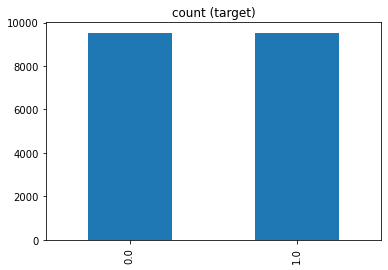

In [13]:
# sample from class 0 (overrepresented class) the number of values in class 1 (underrepresented)
class_0_under = class_0.sample(class_count_1, random_state=42)

test_under = pd.concat([class_0_under, class_1], axis=0)

# this gives both classes equal representation
print("total class of 1 and 0:\n",test_under[0].value_counts()) # plot the count after under-sampeling
test_under[0].value_counts().plot(kind='bar', title='count (target)')
plt.show()

# return arrays to be converted to dataloader tensors
X_train_bal = test_under.iloc[:,1:].to_numpy()
y_train_bal = test_under.iloc[:,0].to_numpy()


In [14]:
# convert numpy arrays to tensors
X_train_tensor = torch.from_numpy(X_train_bal)
X_valid_tensor = torch.from_numpy(X_valid)
X_test_tensor = torch.from_numpy(X_test)
y_train_tensor = torch.from_numpy(y_train_bal)
y_valid_tensor = torch.from_numpy(y_valid)
y_test_tensor = torch.from_numpy(y_test)

# create TensorDataset in PyTorch
hcdr_train = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
hcdr_valid = torch.utils.data.TensorDataset(X_valid_tensor, y_valid_tensor)
hcdr_test = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# create dataloader
# DataLoader is implemented in PyTorch, which will return an iterator to iterate training data by batch.
train_batch_size = 96
valid_test_batch_size = 64
trainloader_hcdr = torch.utils.data.DataLoader(hcdr_train, batch_size=train_batch_size, shuffle=True, num_workers=2)
validloader_hcdr = torch.utils.data.DataLoader(hcdr_valid, batch_size=valid_test_batch_size, shuffle=True, num_workers=2)
testloader_hcdr = torch.utils.data.DataLoader(hcdr_test, batch_size=valid_test_batch_size, shuffle=True, num_workers=2)

(118080, 837) (118080,) (36900, 837) (36900,)


In [15]:

#==================================================#
#    Modify START   #
#==================================================#
'''
(input_dataset) - description of input data: size_set_transformed_columns_CR
(hidden_layers_neurons) - A list of the number of neurons in the hidden layers in order. DEFAULT: [32, 16, 8] => 1st hidden layer: 32 neurons, 2nd: 16, 3rd: 8
(opt) - The optimizer function to use: SGD, Adam, etc.,  DEFAULT: optim.SGD
(epochs) - The total number of epochs to train your model for,  DEFAULT: 5
(learning_rate) - The learning rate to take the gradient descent step with
'''
input_dataset=f"0.6_agg_orig+trans_bal_{X_train.shape[1]}_CR:0.5-10_ReLU"
hidden_layer_neurons=[128, 64, 32, 16, 8, 4]
opt=optim.Adagrad
epochs=5
learning_rate=5e-3

#==================================================#
#    Modify END #
#==================================================#

model, arch_string, train_accuracy, valid_accuracy, test_accuracy, train_auc, valid_auc, test_auc, recall, balanced_accuracy = run_hcdr_model(
    hidden_layer_neurons,
    opt,
    epochs,
    learning_rate,
    return_model=True
)
    

try: hcdrLog 
except : hcdrLog = pd.DataFrame(
    columns=[
        "Dataset",
        "Architecture string", 
        "Optimizer", 
        "Epochs", 
        "Learning Rate",
        "Train accuracy",
        "Valid accuracy",
        "Test accuracy",
        "Train auc",
        "Valid auc",
        "Test auc", 
        "Recall",
        "Balanced Accuracy"
    ]
)

hcdrLog.loc[len(hcdrLog)] = [
    input_dataset,
    arch_string, 
    f"{opt}", 
    f"{epochs}", 
    f"{learning_rate}",
    f"{train_accuracy}",
    f"{valid_accuracy}",
    f"{test_accuracy}",
    f"{train_auc}",
    f"{valid_auc}",
    f"{test_auc}",
    f"{recall}",
    f"{balanced_accuracy}"
]

hcdrLog

--------------------------------------------------
Model:
Sequential(
  (0): Linear(in_features=837, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=32, bias=True)
  (5): ReLU()
  (6): Linear(in_features=32, out_features=16, bias=True)
  (7): ReLU()
  (8): Linear(in_features=16, out_features=8, bias=True)
  (9): ReLU()
  (10): Linear(in_features=8, out_features=4, bias=True)
  (11): ReLU()
  (12): Linear(in_features=4, out_features=2, bias=True)
)
--------------------------------------------------
Epoch 1
----Train Accuracy: 0.5	 Validation Accuracy: 0.081
----Train AUC-ROC: 0.617	 Validation AUC-ROC: 0.67
Epoch 2
----Train Accuracy: 0.637	 Validation Accuracy: 0.739
----Train AUC-ROC: 0.715	 Validation AUC-ROC: 0.745
Epoch 3
----Train Accuracy: 0.707	 Validation Accuracy: 0.701
----Train AUC-ROC: 0.776	 Validation AUC-ROC: 0.753
Epoch 4
----Train Accuracy: 0.718	 Validation A

,Dataset,Architecture string,Optimizer,Epochs,Learning Rate,Train accuracy,Valid accuracy,Test accuracy,Train auc,Valid auc,Test auc,Recall,Balanced Accuracy
0,0.6_agg_orig+trans_bal_837_CR:0.5-10_ReLU,837-128-64-32-16-8-4-2,<class 'torch.optim.adagrad.Adagrad'>,5,0.005,0.726,0.709,0.71,0.797,0.754,0.758,0.71,0.691


In [16]:
hcdrLog

,Dataset,Architecture string,Optimizer,Epochs,Learning Rate,Train accuracy,Valid accuracy,Test accuracy,Train auc,Valid auc,Test auc,Recall,Balanced Accuracy
0,0.6_agg_orig+trans_bal_837_CR:0.5-10_ReLU,837-128-64-32-16-8-4-2,<class 'torch.optim.adagrad.Adagrad'>,5,0.005,0.726,0.709,0.71,0.797,0.754,0.758,0.71,0.691


In [17]:
# hcdrLog = pd.DataFrame(
#     columns=[
#         "Dataset",
#         "Architecture string", 
#         "Optimizer", 
#         "Epochs", 
#         "Learning Rate",
#         "Train accuracy",
#         "Valid accuracy",
#         "Test accuracy",
#         "Train auc",
#         "Valid auc",
#         "Test auc", 
#         "Recall",
#         "Balanced Accuracy"
#     ]
# )

In [18]:
# https://stackoverflow.com/questions/33686747/save-a-list-to-a-txt-file

import pickle
with open('reduced_feat_num.ob', 'wb') as fp:
    pickle.dump(reduced_feat_num, fp)
    
torch.save(model, f"{input_dataset}.pt")

## Predict Test Data with Trained Model

When running this section, restart the kernel and re-run section 1 - Setup cells first. 

### Read-in Test Data

In [5]:
# read-in
DATA_DIR =  "/"

test_ds_names = (
    # "application_train",   
    "application_test", "prevapp_agg_data_tr", "bureau_agg_data_trans_untrans",  
    "ccb_agg_data_tr", "ip_agg_data_tr", "pos_agg_data_tr"
)  

datasets_test = {}

for ds_name in test_ds_names:
    print('---')
    print(ds_name)
    datasets_test[ds_name] = pd.read_csv(os.getcwd() + DATA_DIR + f'{ds_name}.csv')
    datasets_test[ds_name] = reduce_mem_usage(datasets_test[ds_name])

---
application_test
Memory usage of dataframe is 0.04 MB
Memory usage after optimization is: 0.01 MB
Decreased by 79.1%
---
prevapp_agg_data_tr
Memory usage of dataframe is 1.73 MB
Memory usage after optimization is: 0.46 MB
Decreased by 73.2%
---
bureau_agg_data_trans_untrans
Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.21 MB
Decreased by 70.6%
---
ccb_agg_data_tr
Memory usage of dataframe is 0.11 MB
Memory usage after optimization is: 0.04 MB
Decreased by 66.6%
---
ip_agg_data_tr
Memory usage of dataframe is 0.17 MB
Memory usage after optimization is: 0.06 MB
Decreased by 63.4%
---
pos_agg_data_tr
Memory usage of dataframe is 0.34 MB
Memory usage after optimization is: 0.09 MB
Decreased by 73.3%


In [6]:
# denormalize and clean text
for ds_name in datasets_test:
    if ds_name == 'application_test':
        test_data = datasets_test['application_test'].replace(to_replace='\s+', value='_', regex=True) \
                                                    .replace(to_replace='\-', value='_', regex=True) \
                                                    .replace(to_replace='\/', value='_', regex=True) \
                                                    .replace(to_replace='\(', value='', regex=True) \
                                                    .replace(to_replace='\)', value='', regex=True) \
                                                    .replace(to_replace='\:', value='', regex=True) \
                                                    .replace(to_replace='\,', value='', regex=True)
    else:
        test_data = test_data.merge(datasets_test[ds_name], on='SK_ID_CURR', how='left')


test_data = test_data.loc[:,~test_data.columns.str.startswith('Unnamed:')]
test_data = test_data.loc[:,~test_data.columns.str.startswith('SK_ID_PREV')]
# test_data = test_data[
#     (test_data.CODE_GENDER!='XNA')&(test_data.NAME_INCOME_TYPE!='Maternity leave')&(test_data.NAME_FAMILY_STATUS!='Unknown')
# ]

#### OHE Discrepancy EDA

It was observed when trying to train the model that there were some missing columns. This indicated missing category variables in the categorical columns of application_test. Below you can see the features and their missing attributes.

```python
app_test = datasets_test['application_test']  
app_train = pd.read_csv(os.getcwd() + DATA_DIR + 'application_train.csv')
app_train = reduce_mem_usage(app_train)

cat_cols = ['CODE_GENDER', 'NAME_INCOME_TYPE', 'NAME_FAMILY_STATUS']
# cat_cols = feat_cat

print(app_train[cat_cols].apply(lambda col: col.unique()).to_markdown())
print('')
print(app_test[cat_cols].apply(lambda col: col.unique()).to_markdown())
```
[OUT]:

|                    | 0    |
|:-------------------|:-----------------------------------------------------------------------------------------------------------------------------------------------------|
| CODE_GENDER        | ['M', 'F', 'XNA']                                                                                                                                    |
|                    | Categories (3, object): ['F', 'M', 'XNA']                                                                                                            |
| NAME_INCOME_TYPE   | ['Working', 'State servant', 'Commercial associate', 'Pensioner', 'Unemployed', 'Student', 'Businessman', 'Maternity leave']                         |
|                    | Categories (8, object): ['Businessman', 'Commercial associate', 'Maternity leave', 'Pensioner', 'State servant', 'Student', 'Unemployed', 'Working'] |
| NAME_FAMILY_STATUS | ['Single / not married', 'Married', 'Civil marriage', 'Widow', 'Separated', 'Unknown']                                                               |
|                    | Categories (6, object): ['Civil marriage', 'Married', 'Separated', 'Single / not married', 'Unknown', 'Widow']                                       |

|                    | 0    |
|:-------------------|:----------------------------------------------------------------------------------------------------------------------------------|
| CODE_GENDER        | ['F', 'M']                                                                                                                        |
|                    | Categories (2, object): ['F', 'M']                                                                                                |
| NAME_INCOME_TYPE   | ['Working', 'State servant', 'Pensioner', 'Commercial associate', 'Businessman', 'Student', 'Unemployed']                         |
|                    | Categories (7, object): ['Businessman', 'Commercial associate', 'Pensioner', 'State servant', 'Student', 'Unemployed', 'Working'] |
| NAME_FAMILY_STATUS | ['Married', 'Single / not married', 'Civil marriage', 'Widow', 'Separated']                                                       |
|                    | Categories (5, object): ['Civil marriage', 'Married', 'Separated', 'Single / not married', 'Widow']                               |



In [7]:
# create test sets
X_t = test_data.drop(['SK_ID_CURR'], axis = 1) #drop some features with questionable value

X_t.replace([np.inf, -np.inf], np.nan, inplace=True)

print(f"test set           shape: {X_t.shape}")

# determine feature types
id_col, feat_num, feat_cat, feature =  id_num_cat_feature(X_t, text = False)

with open ('reduced_feat_num.ob', 'rb') as fp:
    reduced_feat_num = pickle.load(fp)

test set           shape: (48744, 1461)


### Testing Pipeline

should be exact same as Main

In [8]:
# Pipeline

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(reduced_feat_num)),
    ('imputer',SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown="ignore"))
])

data_pipeline = ColumnTransformer(
    transformers=[
        ("num_pipeline", num_pipeline, feat_num),
        ("cat_pipeline", cat_pipeline, feat_cat)
    ],
    remainder='drop',
    n_jobs=-1
)

In [9]:
X_t = data_pipeline.fit_transform(X_t) #Transform test set with the same constants

# convert numpy arrays to tensors
X_t_tensor = torch.from_numpy(X_t)

print(X_t_tensor.shape)


torch.Size([48744, 837])


In [10]:
model = torch.load(f"0.6_agg_orig+trans_bal_837_CR:0.5-10_ReLU.pt")
model.eval()

t_preds = model(X_t_tensor.float())
t_probs = F.softmax(t_preds, dim=1)[:,1].tolist()

In [11]:
submit_df = datasets_test["application_test"][['SK_ID_CURR']]
submit_df['TARGET'] = t_probs
submit_df.head()

,SK_ID_CURR,TARGET
0,100001,0.275072
1,100005,0.877177
2,100013,0.208998
3,100028,0.347455
4,100038,0.890184


In [12]:
submit_df.to_csv("submission.csv",index=False)